In [64]:
from random import shuffle
import torch
from torch import nn
from torch.nn import init, Module, ReLU, Sequential, ModuleList, Conv2d, MaxPool2d, LeakyReLU, Flatten, Linear, Sigmoid, ConvTranspose2d, BatchNorm2d, Tanh, Dropout2d, Dropout
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm
#from torchinfo import summary
import torch.nn.functional as F
from torch.nn.functional import binary_cross_entropy as bce
torch.autograd.set_detect_anomaly(True)
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from torchvision.utils import save_image
from tqdm.auto import tqdm
import torch.optim as optim

In [65]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
img_size = 128
Z = 100

In [66]:
downsample_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()              
    ])

In [67]:
train_dataset = datasets.ImageFolder('./images/train/',downsample_transform)
test_dataset = datasets.ImageFolder('./images/val/',downsample_transform)
print(f"Train data:\n\n{train_dataset}\n\n\n\nTest data:\n\n{test_dataset}")

Train data:

Dataset ImageFolder
    Number of datapoints: 14630
    Root location: ./images/train/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )



Test data:

Dataset ImageFolder
    Number of datapoints: 1500
    Root location: ./images/val/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [68]:
BATCH_SIZE = 64
BATCH_SIZE_Val = 100
train_dataloader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE_Val)

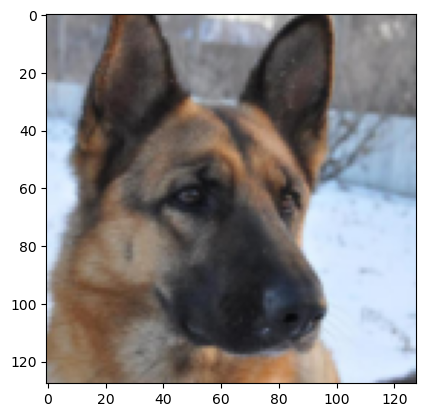

In [69]:
for i in train_dataloader:
    img=i[0][0]
    img = img.permute(1,2,0)
    plt.imshow(img)
    break

In [70]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.bias.data.fill_(0)

In [71]:
class Encoder(torch.nn.Module):
    
    def __init__(self) -> None:
        super(Encoder, self).__init__()

        filter_size = 128

        self.convs = torch.nn.ModuleList([
            Conv2d(3, filter_size, 4, 2, 1, bias=False), 
            BatchNorm2d(filter_size), 
            ReLU(True),

            Conv2d(filter_size, filter_size * 2, 4, 2, 1, bias=False), 
            BatchNorm2d(filter_size * 2), 
            ReLU(True),

            Conv2d(filter_size * 2, filter_size * 4, 4, 2, 1, bias=False), 
            BatchNorm2d(filter_size * 4), 
            ReLU(True),

            Conv2d(filter_size * 4, filter_size * 8, 4, 2, 1, bias=False), 
            BatchNorm2d(filter_size * 8), 
            ReLU(True),

            Conv2d(filter_size * 8, filter_size * 8, 4, 2, 1, bias=False), 
            BatchNorm2d(filter_size * 8), 
            ReLU(True),

            Conv2d(filter_size * 8, filter_size * 8, 4, 2, 1, bias=False), 
            BatchNorm2d(filter_size * 8), 
            ReLU(True),

            Conv2d(filter_size * 8, filter_size * 8, 4, 2, 1, bias=False), 
            BatchNorm2d(filter_size * 8), 
            ReLU(True),

            Conv2d(filter_size * 8, 100, 1, 1),
        ])

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        return x

In [72]:
class Generator(torch.nn.Module):

    def __init__(self) -> None:
        super(Generator, self).__init__()

        filter_size = 64
        self.convs = torch.nn.ModuleList([
            ConvTranspose2d(100, filter_size * 8, 4, 1, 0, bias=False), 
            BatchNorm2d(filter_size* 8), 
            ReLU(inplace=True),

            ConvTranspose2d(filter_size * 8, filter_size * 4, 4, 2, 1, bias=False), 
            BatchNorm2d(filter_size * 4), 
            ReLU(inplace=True),

            ConvTranspose2d(filter_size * 4, filter_size * 2, 4, 2, 1, bias=False), 
            BatchNorm2d(filter_size * 2), 
            ReLU(inplace=True),

            ConvTranspose2d(filter_size * 2, filter_size, 4, 2, 1, bias=False), 
            BatchNorm2d(filter_size), 
            ReLU(inplace=True),

            ConvTranspose2d(filter_size, filter_size, 4, 2, 1, bias=False), 
            BatchNorm2d(filter_size), 
            ReLU(inplace=True),

            ConvTranspose2d(filter_size, 3, 4, 2, 1, bias=False), 
            Tanh()
        ])           
    
    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        return x

In [73]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        filter_size = 128
        # Inference over x
        self.conv_img = torch.nn.ModuleList([
            Conv2d(3, filter_size, 4, 2, 1), 
            LeakyReLU(0.2),

            Conv2d(filter_size, filter_size * 2, 4, 2, 1), 
            BatchNorm2d(filter_size * 2),
            LeakyReLU(0.2),

            Conv2d(filter_size * 2, filter_size * 4, 4, 2, 1), 
            BatchNorm2d(filter_size * 4),
            LeakyReLU(0.2),

            Conv2d(filter_size * 4, filter_size * 4, 4, 2, 1), 
            BatchNorm2d(filter_size * 4),
            LeakyReLU(0.2),

            Conv2d(filter_size* 4, filter_size * 4, 4, 2, 1), 
            BatchNorm2d(filter_size * 4),
            LeakyReLU(0.2),
            
            Conv2d(filter_size* 4, filter_size * 4, 4, 2, 1), 
            BatchNorm2d(filter_size * 4),
            LeakyReLU(0.2),

            Conv2d(filter_size* 4, filter_size * 4, 4, 2, 1), 
            LeakyReLU(0.2),
        ])

        self.conv_latent = torch.nn.ModuleList([
            Conv2d(100, 512, 1, 1, 0), 
            LeakyReLU(0.2),

            Conv2d(512, 512, 1, 1, 0), 
            LeakyReLU(0.2)
        ])

        self.conv_both = torch.nn.ModuleList([
            Conv2d(1024, 2048, 1, 1, 0), 
            LeakyReLU(0.2),

            Conv2d(2048, 2048, 1, 1, 0), 
            LeakyReLU(0.2),

            Conv2d(2048, 1, 1, 1, 0),
            torch.nn.Sigmoid()
        ])
        
     
    def forward(self, x, z):
        for conv in self.conv_img:
            x = conv(x)
        for conv in self.conv_latent:
            z = conv(z)
        xz = torch.cat((x, z), dim=1)
        for conv in self.conv_both:
            xz = conv(xz)
        return xz

In [74]:
discriminator = Discriminator().to(device)
encoder = Encoder().to(device)
generator = Generator().to(device) 

In [16]:
discriminator.apply(weights_init)
encoder.apply(weights_init)
generator.apply(weights_init)
optim_generator = torch.optim.Adam([{'params' : encoder.parameters()},
                         {'params' : generator.parameters()}],lr=0.0002,betas=(0.5,0.999))
optim_discriminator = torch.optim.Adam(discriminator.parameters(),lr=0.0002,betas=(0.5,0.999))

    

In [ ]:
epochs = 200
d_l=[]
g_l=[]
for epoch in range(epochs):
    i=0
    d_loss = 0
    g_loss = 0 
    for x , _ in tqdm(train_dataloader):
        x_real = x.to(device)
        z_real = torch.randn((64, Z, 1, 1)).to(device)

        x_fake = generator(z_real)
        z_fake = encoder(x_real)

        real_preds = discriminator(x_real , z_fake)
        fake_preds = discriminator(x_fake , z_real)

        dis_loss = F.binary_cross_entropy(real_preds.squeeze() , torch.ones((len(real_preds),)).to(device)) + F.binary_cross_entropy(fake_preds.squeeze() , torch.zeros((len(fake_preds),)).to(device))
        gen_loss = F.binary_cross_entropy(real_preds.squeeze() , torch.zeros((len(real_preds),)).to(device)) + F.binary_cross_entropy(fake_preds.squeeze() , torch.ones((len(fake_preds),)).to(device))

        d_loss += dis_loss.item()
        g_loss += gen_loss.item()

        if(i%5==0):
            optim_generator.zero_grad()
            gen_loss.backward()
            optim_generator.step()
        else:
            optim_discriminator.zero_grad()
            dis_loss.backward()
            optim_discriminator.step()
        i +=1
    print(f"Epoch : [{epoch+1}]  Dis-Loss : {round(d_loss,8)}   Gen-Loss : {round(g_loss,8)}")

    d_l.append(d_loss)
    g_l.append(g_loss)

    torch.save(encoder.state_dict() , "BiGanEncoder.pth")
    torch.save(generator.state_dict() , "BiGanGenerator.pth")




    #Generation
    if(epoch % 10 ==0):
        gen_latent = torch.randn(100,100,1,1).to(device)
        gen_images = generator(gen_latent)
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(vutils.make_grid(gen_images[:100], padding=5, nrow=10,normalize=True).cpu(),(1,2,0)))
        plt.show()





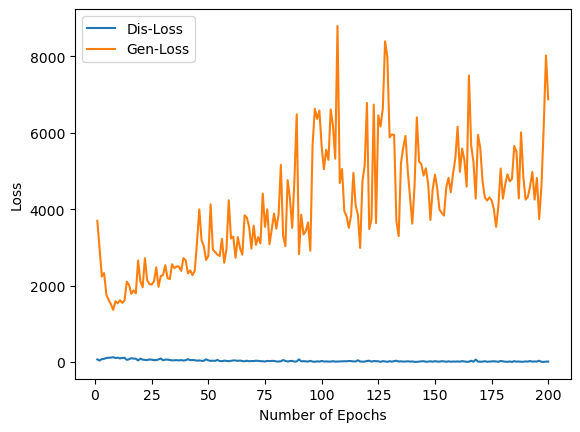

In [85]:
#After Training 
Dis_Loss = [69.47421158096404, 41.99696132415556, 76.89691006042995, 85.97224633442238, 109.2611510748975, 113.69490024633706, 118.0876449206844, 127.9476322568953, 105.49709337949753, 116.86588135408238, 95.87637991830707, 109.10078983008862, 112.77668193913996, 58.509689655853435, 74.26992669142783, 102.60989089682698, 91.63125013536774, 88.99096589069813, 42.48224490392022, 89.20480389380828, 65.48545474465936, 56.327815879136324, 53.862211655592546, 68.37339844298549, 63.10679697105661, 52.64692415390164, 51.44612467836123, 69.29952162876725, 94.66290509747341, 47.943828489398584, 65.10915607749484, 66.05605080351233, 56.621768484590575, 44.89793784142239, 47.60249555518385, 50.71471634382033, 45.11076712195063, 52.206099179107696, 42.386930095613934, 49.84140398458112, 75.11800928972661, 49.91507042560261, 54.038818393368274, 49.55031325004529, 37.36108853621408, 44.429947971744696, 32.15521172186709, 34.94496869674185, 73.13646402850281, 44.2747359406203, 32.081468384421896, 36.29104227673088, 31.498225752060534, 56.01872273499612, 28.14207676317892, 24.880809745998704, 38.34327029885026, 29.766597987851128, 23.659180268850832, 32.604949842148926, 43.19311469892273, 42.43780954997055, 32.10360525129363, 41.12035295677197, 25.900441030738875, 20.130414663639385, 35.708929969485325, 22.33700155816041, 28.076218552450882, 26.374573652130493, 35.6049346888467, 32.072638875077246, 23.88821385479241, 22.711162318293646, 15.680769557680833, 31.251364648502204, 24.814194604434306, 30.665473026201653, 30.652076159494754, 16.68956794484984, 15.784655041661608, 19.687293883420807, 53.79554090491729, 32.363185358874034, 14.94523431621019, 27.546210227606934, 30.982387413117976, 12.987533255080052, 18.172320837933512, 72.28152415684599, 17.341637703320885, 26.15884307876695, 18.15601352789963, 15.5072025822883, 31.659265166759724, 14.129575132947139, 8.133802327574813, 20.951198543325063, 11.595017292305783, 30.140551470873106, 14.939997803783626, 17.112780067351196, 13.107904794618662, 13.34649403441108, 25.32557337242281, 12.078979369733133, 15.103888679430383, 19.25023069904273, 21.02463676948537, 22.196210693546163, 20.699632162286434, 28.14075706859876, 26.515532505960437, 17.789942724088178, 16.475133454114257, 48.233073549472465, 15.307402778445976, 11.815031373022066, 12.434530666483624, 28.670632004668732, 34.8775521532516, 12.600101405812893, 27.30241329619821, 23.72622097871499, 20.770879989612922, 6.26130913164161, 25.733379497008173, 15.53661776888839, 7.481481303128817, 24.22536092197879, 9.464524525937577, 26.740902493812428, 35.14880022784928, 15.124224785278784, 19.980606739554787, 13.277676834711201, 14.213475035812735, 21.763182999114406, 12.876311257081397, 16.14541739528613, 6.735079486205905, 6.4405968290498095, 13.289570919847392, 19.515694061425165, 24.044572549828445, 9.395435089148123, 12.185496497395434, 20.824376565535204, 10.878935615187402, 23.595656174926262, 15.659236756604514, 11.169077907703468, 23.882063762136568, 18.63961528740765, 8.66468752676883, 20.638281259096402, 9.349866247241152, 14.83255671287452, 12.97935469965887, 17.002078272236304, 10.450213449457806, 25.79743848372209, 15.5974806425329, 7.219788212440108, 10.275426225936826, 34.478349454216186, 8.91069067810895, 65.895989764751, 13.585762746246019, 8.948030467300669, 13.10021241857612, 22.467075167034636, 8.756203457844094, 13.824202417110428, 19.54638041138969, 21.847564517112914, 15.013451787715894, 8.731904931257304, 28.91823782627671, 19.06238973177824, 10.266028377853218, 6.862899703417497, 16.8986448082469, 4.639779194290895, 24.22986319798747, 11.081366740103476, 16.351663468201878, 7.828718863207541, 9.591030159635011, 17.370740183607268, 14.099453520293537, 27.175275911195058, 12.45785105439245, 15.371542711436632, 15.227069938675413, 35.11569147375121, 7.743031078272907, 5.180476137266396, 12.542468932260363, 13.243562789145471]
Gen_Loss = [3693.316010951996, 2969.5360589027405, 2235.300377011299, 2328.868023753166, 1761.8153595924377, 1621.9081562757492, 1514.7601835727692, 1367.328469634056, 1587.6549648046494, 1538.80788564682, 1617.8334250450134, 1548.7499319314957, 1610.3615653514862, 2102.1945519447327, 2019.6747388839722, 1786.273756146431, 1876.0191941261292, 1799.7638976573944, 2658.7410073280334, 2114.5128866434097, 1957.1694254875183, 2716.8442990779877, 2144.3357322216034, 2038.3936240673065, 2029.0092787742615, 2109.592692375183, 2477.867075443268, 1968.1159262657166, 2249.6600816249847, 2274.3851714134216, 2535.2397084236145, 2195.545909643173, 2170.8480796813965, 2559.099410533905, 2455.267460346222, 2499.939455986023, 2501.706012248993, 2385.091009616852, 2718.3371539115906, 2663.51349401474, 2320.5298647880554, 2397.467886209488, 2274.0606718063354, 2389.2423429489136, 3143.1330280303955, 3992.8495321273804, 3187.3040833473206, 3027.102174758911, 2671.473888874054, 2778.668745994568, 4123.2985644340515, 2938.64972782135, 2877.175154209137, 2809.2390236854553, 2774.7646474838257, 3225.8376207351685, 2598.217276096344, 2952.209209918976, 4232.134973526001, 3231.7583770751953, 3280.934991836548, 2728.3832273483276, 3268.8963680267334, 2977.909837245941, 2809.952751636505, 3841.2783312797546, 3775.724805831909, 3537.0474920272827, 2970.1958332061768, 3570.264265060425, 3065.0111746788025, 3268.0641741752625, 3103.4951634407043, 4408.356184959412, 3537.2701749801636, 3994.3970861434937, 3083.172523498535, 3482.5199494361877, 3885.1664934158325, 3490.603518009186, 3861.191767692566, 5158.068880081177, 3310.5416054725647, 3031.002073287964, 4759.372367858887, 4291.932168960571, 3510.352207660675, 4790.875820159912, 6479.760144233704, 2822.3860759735107, 3855.806993484497, 3337.6472539901733, 3424.5161061286926, 3651.268385887146, 2911.562162876129, 5683.268955230713, 6625.503617286682, 6359.486186027527, 6579.470942497253, 5648.904793739319, 5042.905152320862, 5552.613134384155, 5289.29571723938, 6605.871908187866, 6173.632327079773, 5319.424011230469, 8791.530878067017, 4682.262145042419, 5050.453644752502, 3945.9040536880493, 3813.719898223877, 3511.5765771865845, 3833.025550842285, 4948.946245193481, 4098.748503684998, 3856.85919046402, 2986.3230390548706, 4727.1701946258545, 5145.968479156494, 6775.430362701416, 3479.852340698242, 3740.150870323181, 6733.390488624573, 3632.0584950447083, 6452.683674812317, 6162.150433063507, 6632.339288711548, 8389.025392532349, 7972.34522819519, 5877.277133464813, 5954.070623397827, 5941.087474822998, 3674.5320587158203, 3294.361533164978, 5194.561448097229, 5610.800096511841, 5914.452631950378, 5012.233133792877, 4306.9963121414185, 3621.2797298431396, 4594.247648239136, 6401.528580665588, 5249.157885551453, 5175.70681476593, 4876.780950546265, 5067.778398513794, 4665.559078216553, 3717.6826639175415, 4515.059720039368, 4902.5541915893555, 4546.371169090271, 3990.5622539520264, 3901.9275069236755, 3833.0227632522583, 4568.785620689392, 4820.553715705872, 4440.161984443665, 4933.501026153564, 5329.621643066406, 6156.28798866272, 4976.664429664612, 5583.685080051422, 5281.418413162231, 4588.543030738831, 7497.170308113098, 5663.144791603088, 5231.649703979492, 4276.665284156799, 5943.313236236572, 5601.083745002747, 4735.707901000977, 4313.262855529785, 4225.398252487183, 4308.0545353889465, 4234.118371963501, 4000.7681741714478, 3536.849111557007, 4079.5531969070435, 5062.424414634705, 4274.134414672852, 4640.58233833313, 4911.336566925049, 4728.106282711029, 4792.0735540390015, 5652.264665603638, 5498.2566022872925, 4279.823558807373, 6008.240923881531, 4852.660987854004, 4250.10931968689, 4318.788592338562, 4600.218224525452, 4974.456545829773, 4249.860410690308, 4815.762724876404, 3740.1643047332764, 4592.307934761047, 6140.548340797424, 8020.035840034485, 6871.503207206726]
X_vals = [i for i in range(1,201)]
plt.plot(X_vals,Dis_Loss , label = "Dis-Loss")
plt.plot(X_vals,Gen_Loss , label = "Gen-Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()


In [75]:
generator.load_state_dict(torch.load("./BiGanGenerator.pth"))
generator.eval()

Generator(
  (convs): ModuleList(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d

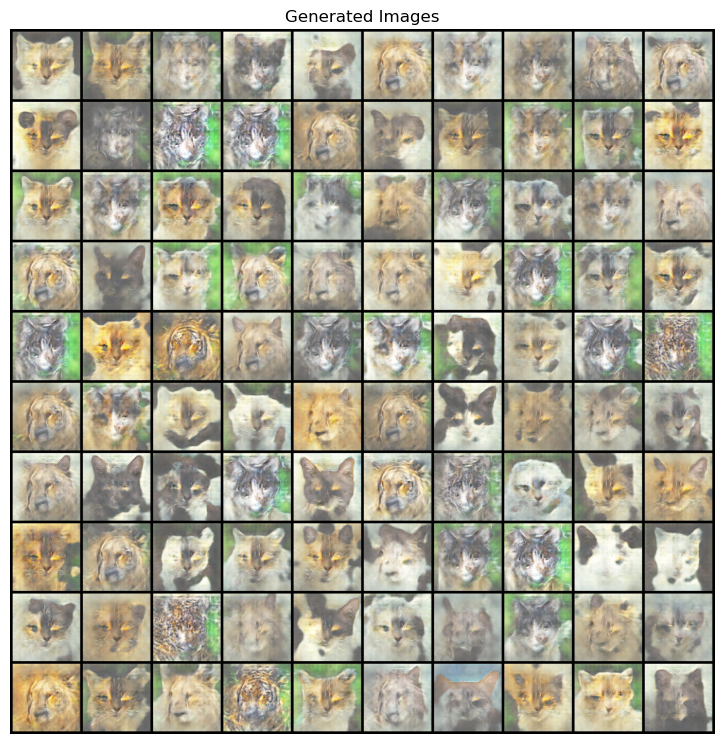

In [76]:
gen_latent = torch.randn(100,100,1,1).to(device)
gen_images = generator(gen_latent)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(gen_images[:100], padding=5, nrow=10,normalize=True).cpu(),(1,2,0)))
plt.show()

In [77]:
encoder.load_state_dict(torch.load("./BiGanEncoder.pth"))
encoder.eval()
    

Encoder(
  (convs): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(1024, eps=1e-05, momentu

In [47]:
X = []
y = []
for x , _ in tqdm(train_dataloader):
    x = x.to(device)
    embed = encoder(x).squeeze(2).squeeze(2).cpu().detach().numpy()
    for i in range(len(_)):
        X.append(embed[i])
        y.append(_[i])

  0%|          | 0/229 [00:00<?, ?it/s]

In [48]:
X_test =[]
y_test =[]
for x , _ in tqdm(test_dataloader):
    x = x.to(device)
    embed = encoder(x).squeeze(2).squeeze(2).cpu().detach().numpy()
    for i in range(len(_)):
        X_test.append(embed[i])
        y_test.append(_[i])

  0%|          | 0/15 [00:00<?, ?it/s]

In [54]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


In [55]:
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X, y)

In [56]:
poly_pred = poly.predict(X_test)

In [57]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))


Accuracy (Polynomial Kernel):  84.73
F1 (Polynomial Kernel):  84.79


In [61]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(random_state=0 , max_iter=10000).fit(X, y)

In [62]:
logistic_pred = logistic.predict(X_test)

In [86]:
logistic_accuracy = accuracy_score(y_test, logistic_pred)
logistic_f1 = f1_score(y_test, logistic_pred, average='weighted')
print('Accuracy (Logistic Regression): ', "%.2f" % (logistic_accuracy*100))
print('F1 (Logistic Regression): ', "%.2f" % (logistic_f1*100))

Accuracy (Logistic Regression):  85.40
F1 (Logistic Regression):  85.42
